In [1]:
import pickle
import os
import numpy as np

In [2]:
from quchem_ibm.exp_analysis import *

def dict_of_M_to_list(M_dict, PauliOP):
    
    P_Qubit_list, _ = zip(*(list(*PauliOP.terms.keys())))
    
    list_of_M_bitstrings=None
    for bit_string, N_obtained in M_dict.items():
        
        M_string = np.take(list(bit_string[::-1]), P_Qubit_list) # only take terms measured! Note bitstring reversed!
        
        array_meas = np.repeat(''.join(M_string), N_obtained)
        if list_of_M_bitstrings is None:
            list_of_M_bitstrings=array_meas
        else:
            list_of_M_bitstrings=np.hstack((list_of_M_bitstrings,array_meas))
    
    # randomly shuffle (seed means outcome will always be the SAME!)
#     np.random.seed(42) 
    np.random.shuffle(list_of_M_bitstrings) 
    
    return list_of_M_bitstrings

In [3]:
# # input for exp
base_dir = os.getcwd()
input_file = os.path.join(base_dir, 'LiH_simulation_RESULTS_time=2020Oct07-163210198971.pickle')
with open(input_file, 'rb') as handle:
    LiH_data = pickle.load(handle)


In [4]:
experimental_data_SEQ_ROT = LiH_data['experiment_data'].copy()

del LiH_data

In [5]:
SEQ_ROT_data = experimental_data_SEQ_ROT[101852100]['seq_rot'].copy()
del experimental_data_SEQ_ROT


In [6]:
SEQ_ROT_Hist_data_sim={}
    
for exp_instance in SEQ_ROT_data: 
    for exp_dict_key in exp_instance:

        exp_dict= exp_instance[exp_dict_key]

        if 'Ps' in exp_dict.keys():
            P=exp_dict['Ps']
            coeff = exp_dict['gamma_l']

            measured_dict_sim = exp_dict['measurement_dict']

        else:
            P=exp_dict['qubitOp']
            coeff = exp_dict['coeff']
            measured_dict_sim = exp_dict['measurement_dict']

        M_list_sim = dict_of_M_to_list(measured_dict_sim, P)

        if exp_dict_key in SEQ_ROT_Hist_data_sim.keys():
            SEQ_ROT_Hist_data_sim[exp_dict_key]={'P':P ,'coeff': coeff, 'Measurements': np.hstack((SEQ_ROT_Hist_data_sim[exp_dict_key]['Measurements'],M_list_sim))}
        else:
            SEQ_ROT_Hist_data_sim[exp_dict_key]={'P':P ,'coeff': coeff, 'Measurements': M_list_sim}


In [7]:
SEQ_ROT_Hist_data_sim[0]['Measurements'].shape

(9985500,)

In [8]:
# ### save output
# np.save('LCU_hist_data', STANDARD_Hist_data_sim)

In [9]:
import matplotlib.pyplot as plt

In [10]:
fci_energy= -7.971184315565538

# Histogram

In [11]:
from tqdm.notebook import tqdm
def Get_Hist_data(Histogram_data, I_term):
    E_list=[]
    for m_index in tqdm(range(Histogram_data[0]['Measurements'].shape[0])):
        E=I_term
        for M_dict_key in Histogram_data:
            coeff = Histogram_data[M_dict_key]['coeff']
            parity =  1 if sum(map(int, Histogram_data[M_dict_key]['Measurements'][m_index])) % 2 == 0 else -1
            E+=coeff*parity
        E_list.append(E)
    return E_list
    

In [12]:
I_term = -4.142299396835105
E_list_SEQ_ROT_sim=Get_Hist_data(SEQ_ROT_Hist_data_sim, I_term)

In [13]:
E_list_SEQ_ROT_sim=np.array(E_list_SEQ_ROT_sim, dtype=float).tolist()

/Users/lex/anaconda3/envs/UpdatedCirq/lib/python3.7/site-packages/ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


In [14]:
import json

In [15]:
with open("E_list_SEQ_ROT_sim.json", "w") as write_file:
    json.dump(E_list_SEQ_ROT_sim, write_file)

In [16]:
with open("E_list_SEQ_ROT_sim.json", "r") as read_file:
    E_list_SEQ_ROT_sim = json.load(read_file)


In [17]:
E_list_SEQ_ROT_sim=np.array(E_list_SEQ_ROT_sim)

In [22]:
def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp( - ((x - mean)**2 / (2*standard_deviation**2)))

In [19]:
from scipy.optimize import curve_fit

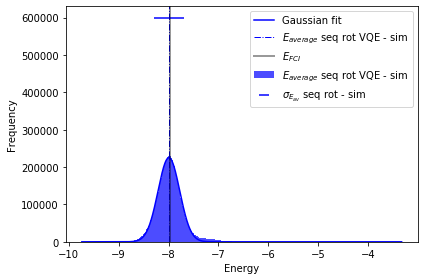

In [20]:
# from matplotlib import pyplot
# %matplotlib inline


# # bins = len(set(E_list_SEQ_ROT_sim))
# bins = 500


# bin_heights_SEQ_ROT_sim, bin_borders_SEQ_ROT_sim, _=pyplot.hist(E_list_SEQ_ROT_sim, 
#                                                                 bins, alpha=0.7, 
#                                                                 label='$E_{average}$ seq rot VQE - sim', 
#                                                                 color='b',
#                                                               density=False)

# bin_centers_SEQ_ROT_sim = bin_borders_SEQ_ROT_sim[:-1] + np.diff(bin_borders_SEQ_ROT_sim) / 2
# popt, _ = curve_fit(gaussian, bin_centers_SEQ_ROT_sim, bin_heights_SEQ_ROT_sim, p0=[fci_energy, 0, 1], **{'maxfev':10000})
# mean_SEQ_ROT_sim, amplitude_SEQ_ROT_sim, standard_deviation_SEQ_ROT_sim= popt
# x_interval_for_fit = np.linspace(bin_borders_SEQ_ROT_sim[0], bin_borders_SEQ_ROT_sim[-1], 10000)
# pyplot.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='Gaussian fit', color='b')


# pyplot.axvline(mean_SEQ_ROT_sim, color='b', linestyle='dashdot', linewidth=1, 
#             label='$E_{average}$ seq rot VQE - sim') # mean of GAUSSIAN FIT

# # pyplot.axvline(E_list_SEQ_ROT_sim.mean(), color='b', linestyle='dashdot', linewidth=1, 
# #             label='$E_{average}$ seq rot VQE - sim') # mean of DATA

# pyplot.errorbar(mean_SEQ_ROT_sim, 600_000,
#              xerr=standard_deviation_SEQ_ROT_sim, linestyle="None", color='b',
#              uplims=True, lolims=True, label='$\sigma_{E_{av}}$ seq rot - sim')




# pyplot.axvline(fci_energy, color='k', linestyle='solid', linewidth=2, 
#             label='$E_{FCI}$', alpha=0.4)

# pyplot.legend(loc='upper right')
# # pyplot.legend(bbox_to_anchor=(0.865,1.9), loc="upper left")
# pyplot.ylabel('Frequency')
# pyplot.xlabel('Energy')

# pyplot.tight_layout()

# file_name = 'LiH_Histogram_sim_SEQ_ROT_Gaussian.jpeg'
# pyplot.savefig(file_name, dpi=300,transparent=True,) # edgecolor='black', facecolor='white')
# pyplot.show()

In [21]:
len(set(np.around(E_list_SEQ_ROT_sim, 5)))

217802

In [27]:
# https://stats.stackexchange.com/questions/798/calculating-optimal-number-of-bins-in-a-histogram
from scipy.stats import iqr

bin_width = 2 * iqr(E_list_SEQ_ROT_sim) / E_list_SEQ_ROT_sim.shape[0]**(1/3)
np.ceil((max(E_list_SEQ_ROT_sim)-min(E_list_SEQ_ROT_sim))/bin_width)

2265.0

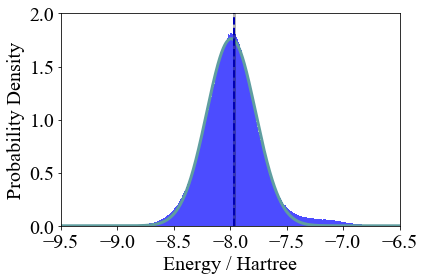

In [30]:
from matplotlib import pyplot
%matplotlib inline


# bins = 210_000
bins = 2500


bin_heights_SEQ_ROT_sim, bin_borders_SEQ_ROT_sim, _=pyplot.hist(E_list_SEQ_ROT_sim, 
                                                                bins, alpha=0.7, 
                                                                label='$E_{average}$ seq rot VQE - sim', 
                                                                color='b',
                                                              density=True)

### Gaussian Fit
bin_centers_SEQ_ROT_sim = bin_borders_SEQ_ROT_sim[:-1] + np.diff(bin_borders_SEQ_ROT_sim) / 2
popt, _ = curve_fit(gaussian, bin_centers_SEQ_ROT_sim, bin_heights_SEQ_ROT_sim, p0=[fci_energy, 0, 1], **{'maxfev':10000})
mean_SEQ_ROT_sim, amplitude_SEQ_ROT_sim, standard_deviation_SEQ_ROT_sim= popt
x_interval_for_fit = np.linspace(bin_borders_SEQ_ROT_sim[0], bin_borders_SEQ_ROT_sim[-1], 10000)
pyplot.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='Gaussian fit', color='cadetblue',
           linewidth=3)



### Average Energy
pyplot.axvline(np.mean(E_list_SEQ_ROT_sim), color='b', linestyle='--', linewidth=2, 
            label='$E_{average}$ seq rot VQE - sim') # mean of GAUSSIAN FIT


##############
# chemical accuracy
pyplot.axvline(fci_energy, color='k', linestyle='solid', linewidth=3, 
            label='$E_{FCI}$', alpha=0.3)

# # chemical accuracy
# pyplot.fill_between([fci_energy-1.6e-3, fci_energy+1.6e-3],
#                  [0, np.ceil(max(bin_heights_STANDARD))] ,
#                  color='k', 
#                  label='chemical accuracy',
#                 alpha=0.5)


pyplot.rcParams["font.family"] = "Times New Roman"
pyplot.ylabel('Probability Density', fontsize=20)
pyplot.xlabel('Energy / Hartree', fontsize=20)
pyplot.xticks(np.arange(-9.5,-5.5,0.5), fontsize=20)
pyplot.yticks(np.arange(0,2.5,0.5), fontsize=20)

# pyplot.xlim(np.floor(min(bin_borders_STANDARD)), np.ceil(max(bin_borders_STANDARD)))
pyplot.xlim(-9.5, -6.5)

pyplot.tight_layout()

file_name = 'LiH_Histogram_sim_SEQ_ROT_Gaussian.jpeg'
pyplot.savefig(file_name, dpi=300,transparent=True,) # edgecolor='black', facecolor='white')
pyplot.show()